# CNN + Transfer learning 練習

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dense, Dropout, Activation,
                                     Flatten, GlobalAveragePooling2D)
import tensorflow as tf

## Where AM I 資料讀入及前處理

In [4]:
data_path = "/datasets/aia-data2020/where_am_i/train"

x_data_list = []
y_data_list = []
for roots, dirs, files in os.walk(data_path):
    for each in files:
        if each.find('checkpoint') == -1:
            x_data_list.append(os.path.join(roots.split("/")[-1], each))
            y_data_list.append(roots.split("/")[-1])

In [5]:
data_list = pd.DataFrame({})
data_list['img_path'] = x_data_list
data_list['label'] = y_data_list

In [6]:
data_list.head(3)

img_path    label
0  highway/image_0048.jpg  highway
1  highway/image_0082.jpg  highway
2  highway/image_0112.jpg  highway

In [7]:
from sklearn.model_selection import train_test_split

train_list, test_list = train_test_split(data_list,
                                         test_size=0.1,
                                         random_state=42,
                                         stratify=data_list['label'].values)

In [8]:
img_size = 224
num_class = len(data_list['label'].unique())

## 讀入 Pre-trained Model

In [9]:
from tensorflow.keras.applications.resnet import (ResNet50, preprocess_input)

In [10]:
pre_model = ResNet50(weights='imagenet', include_top=False,
                     input_shape=(img_size, img_size, 3))

x = GlobalAveragePooling2D()(pre_model.output)
# x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
outputs = Dense(num_class, activation='softmax')(x)


model = Model(inputs=pre_model.inputs, outputs=outputs)

In [11]:
# model.summary()

# 決定 Pre-Train 參數量

In [12]:
pre_model.trainable = True

# trainable_layer = 10
# for layer in pre_model.layers[:-trainable_layer]:
#     layer.trainable = False

# for layer in model.layers:
#     print(layer, layer.trainable)

# model.summary()

In [13]:
learning_rate = 1e-5
optimizer = keras.optimizers.Adam(lr=learning_rate)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Data Augmentation

In [14]:
batch_size = 32
num_steps = len(train_list) // batch_size + 1
num_epochs = 10

In [15]:
train_datagen = ImageDataGenerator(
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   preprocessing_function=preprocess_input
                                  )
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [16]:
img_shape = (img_size, img_size)

train_generator = train_datagen.flow_from_dataframe(
                                                    dataframe=train_list,
                                                    directory=data_path,
                                                    x_col="img_path",
                                                    y_col="label",
                                                    target_size=img_shape,
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

valid_generator = test_datagen.flow_from_dataframe(
                                                    dataframe=test_list,
                                                    directory=data_path,
                                                    x_col="img_path",
                                                    y_col="label",
                                                    target_size=img_shape,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

# 用在不知道 label 的資料讀取上
# test_generator = test_datagen.flow_from_dataframe(
#                                                     dataframe=test_list,
#                                                     directory=data_path,
#                                                     x_col="img_path",
#                                                     target_size=img_shape,
#                                                     batch_size=batch_size,
#                                                     class_mode=None,
#                                                     shuffle=False)


Found 2686 validated image filenames belonging to 15 classes.
Found 299 validated image filenames belonging to 15 classes.


## 開始訓練模型

In [17]:
model_dir = 'model-logs/resnet50'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

logfiles = model_dir + '/{}-{}'.format('basic_model',
                                       model.__class__.__name__)
model_cbk = keras.callbacks.TensorBoard(log_dir=logfiles,
                                        histogram_freq=1)

modelfiles = model_dir + '/{}-best-model.h5'.format('basic_model')
model_mckp = keras.callbacks.ModelCheckpoint(modelfiles,
                                             monitor='val_accuracy',
                                             save_best_only=True)

earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                          patience=5,
                                          verbose=1)


callbacks_list = [model_cbk, model_mckp, earlystop]

In [18]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=num_steps,
                              epochs=num_epochs,
                              validation_data=valid_generator,
                              callbacks=callbacks_list)

Epoch 1/10
84/84 [==============================] - 37s 444ms/step - loss: 2.3795 - accuracy: 0.2677 - val_loss: 1.7812 - val_accuracy: 0.5017
Epoch 2/10
84/84 [==============================] - 37s 440ms/step - loss: 1.2601 - accuracy: 0.6433 - val_loss: 0.9949 - val_accuracy: 0.7559
Epoch 3/10
84/84 [==============================] - 35s 422ms/step - loss: 0.7320 - accuracy: 0.7997 - val_loss: 0.6214 - val_accuracy: 0.8194
Epoch 4/10
84/84 [==============================] - 36s 429ms/step - loss: 0.5083 - accuracy: 0.8675 - val_loss: 0.4712 - val_accuracy: 0.8629
Epoch 5/10
84/84 [==============================] - 36s 427ms/step - loss: 0.3825 - accuracy: 0.8961 - val_loss: 0.3937 - val_accuracy: 0.8729
Epoch 6/10
84/84 [==============================] - 35s 414ms/step - loss: 0.2952 - accuracy: 0.9218 - val_loss: 0.3143 - val_accuracy: 0.8829
Epoch 7/10
84/84 [==============================] - 35s 415ms/step - loss: 0.2343 - accuracy: 0.9348 - val_loss: 0.2854 - val_accuracy: 0.9064

## 訓練結果視覺化

In [19]:
loss, acc = model.evaluate_generator(valid_generator, verbose=2)

10/10 - 1s - loss: 0.2313 - accuracy: 0.9365


In [20]:
y_pred = model.predict_generator(valid_generator)
y_pred = y_pred.argmax(-1)

In [21]:
y_test = valid_generator.classes
class_name = valid_generator.class_indices
class_names = np.array([each for each in class_name.keys()])

In [22]:
from sklearn.metrics import accuracy_score, confusion_matrix

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.9364548494983278
[[14  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 11  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0 25  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 22  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  1  0 13  0  1  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0 18  0  0  0  1  0  2  0  0]
 [ 1  0  0  0  0  0  0 19  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 10  1  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0 18  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 26  1  0  0  0]
 [ 0  0  0  2  0  0  0  0  0  0  1 28  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0 21  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 19  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1 25]]


Text(0.5, 1.0, 'Confusion Matrix')

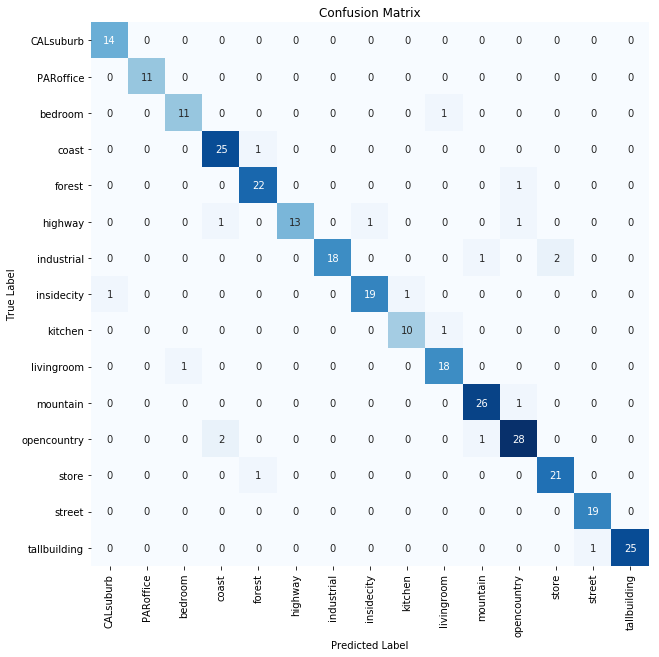

In [23]:
import seaborn as sns

matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(matrix, annot=True, cbar=False, cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

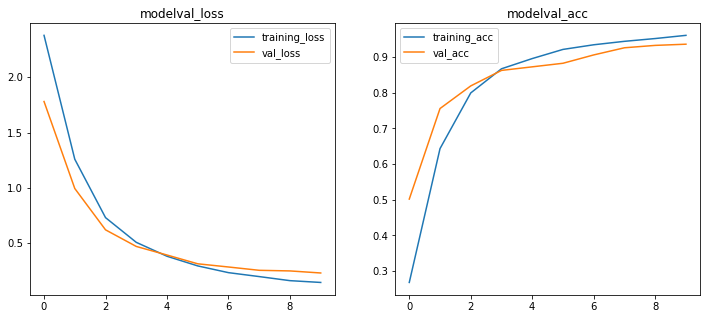

In [24]:
train_history = ['loss', 'val_loss', 'accuracy', 'val_accuracy']
name_history = ['training_loss', 'val_loss', 'training_acc', 'val_acc']

plt.figure(figsize=(12, 5))
for eachx, eachy, i in zip(train_history, name_history, range(4)):
    if i % 2 == 0:
        plt.subplot(1, 2, i//2+1)
    l_x = len(history.history[eachx])
    plt.plot(np.arange(l_x), history.history[eachx], label=eachy)
    plt.legend(loc='best')
    plt.title('model'+eachy)
plt.show()